In [21]:
import math
import matplotlib.pyplot as plt
import numpy as np

import czifile
from pathlib import Path
import os
from skimage import morphology, exposure, filters
from skimage.feature import canny
from skimage.measure import regionprops, regionprops_table, label
from scipy import ndimage, misc

In [2]:
# replace with a configuration file
channel_dict = {'DAPI': 0, 'gt':2, 'pho':3, 'hb':4}
z_plane = 27 # midsaggital slice variable
bkgd_signal = 150
file_name = 'wt_20210510_gthb_5.czi'
work_dir = '/Users/robinhood/Dropbox (HMS)/Data/imaging/processing'
channel_list = ['DAPI', 'gt', 'pho', 'hb'] #keep for iteration
shape_channel = 'DAPI'
ap_channel = 'DAPI'
dv_channel = 'hb'
kd_channel = 'pho'
out_channels = ['gt', 'hb']
xdim = 1024
ydim = 1024

In [3]:
# uploading the file
os.chdir(work_dir)

cur_dir = Path.cwd()
print(f"The current directory is {cur_dir}\n")

# specify a relative or absolute directory
#data_dir = Path("data")

czi = czifile.imread(file_name)
img=czi.squeeze()

data = {}
for channel in channel_list:
    data[channel] = img[channel_dict[channel],...]

The current directory is /Users/robinhood/Dropbox (HMS)/Data/imaging/processing



In [4]:
# get example slices

max_AP = data[ap_channel].max(0) # this will be how to pick AP axis
z_plane_shape = data[shape_channel][z_plane,:,:]
z_plane_dv = data[dv_channel][z_plane,:,:]


In [5]:
#get the edges of the embryo (via single mid slice)

# create the embryo shape for rotation axis extraction
z_plane_normalized = exposure.adjust_gamma(z_plane_shape)
z_hyst_shape = filters.apply_hysteresis_threshold(z_plane_normalized, bkgd_signal, np.max(z_plane_normalized)-1)
zclosed_v1 = morphology.binary_closing(z_hyst_shape)
zedge = canny(zclosed_v1, sigma=2.0, low_threshold=0.55, high_threshold=0.8) 


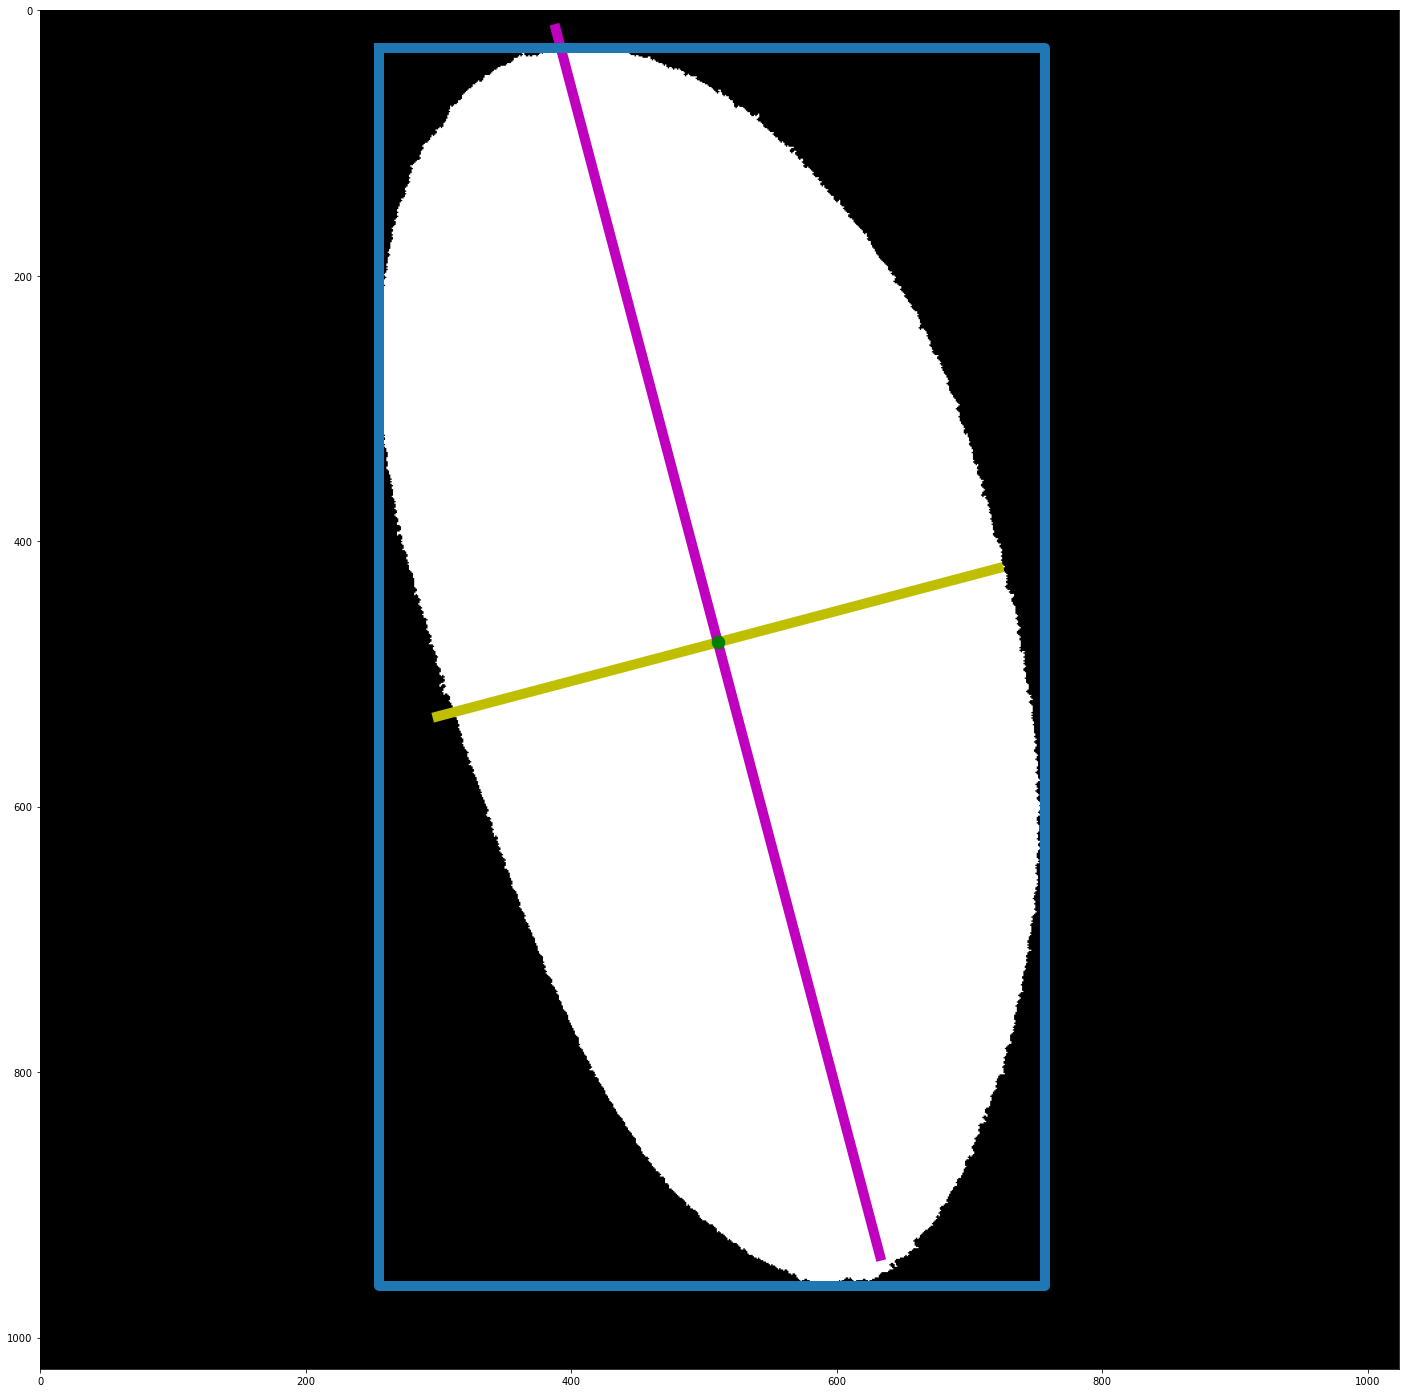

In [31]:
# get the rotation angle for the embryo at mid plane

emb_label= label(zclosed_v1.astype(np.uint8))
emb_regions = regionprops(zclosed_v1.astype(np.uint8))

for props in emb_regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    long_axis = props.major_axis_length
    short_axis = props.minor_axis_length
    minr, minc, maxr, maxc = props.bbox

    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length #top
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x3 = x0 - math.cos(orientation) * 0.5 * props.minor_axis_length #bottom
    y3 = y0 + math.sin(orientation) * 0.5 * props.minor_axis_length
    
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length
    x4 = x0 + math.sin(orientation) * 0.5 * props.major_axis_length
    y4 = y0 + math.cos(orientation) * 0.5 * props.major_axis_length

fig, ax = plt.subplots(figsize=(25,25))
ax.imshow(zclosed_v1, cmap=plt.cm.gray)

ax.plot((x3, x1), (y3, y1), '-y', linewidth=10) #minor axis line
ax.plot((x4, x2), (y4, y2), '-m', linewidth=10) #major axis line
ax.plot(x0, y0, '.g', markersize=25)

bx = (minc, maxc, maxc, minc, minc)
by = (minr, minr, maxr, maxr, minr)
ax.plot(bx, by, '-p', linewidth=10)

plt.show()

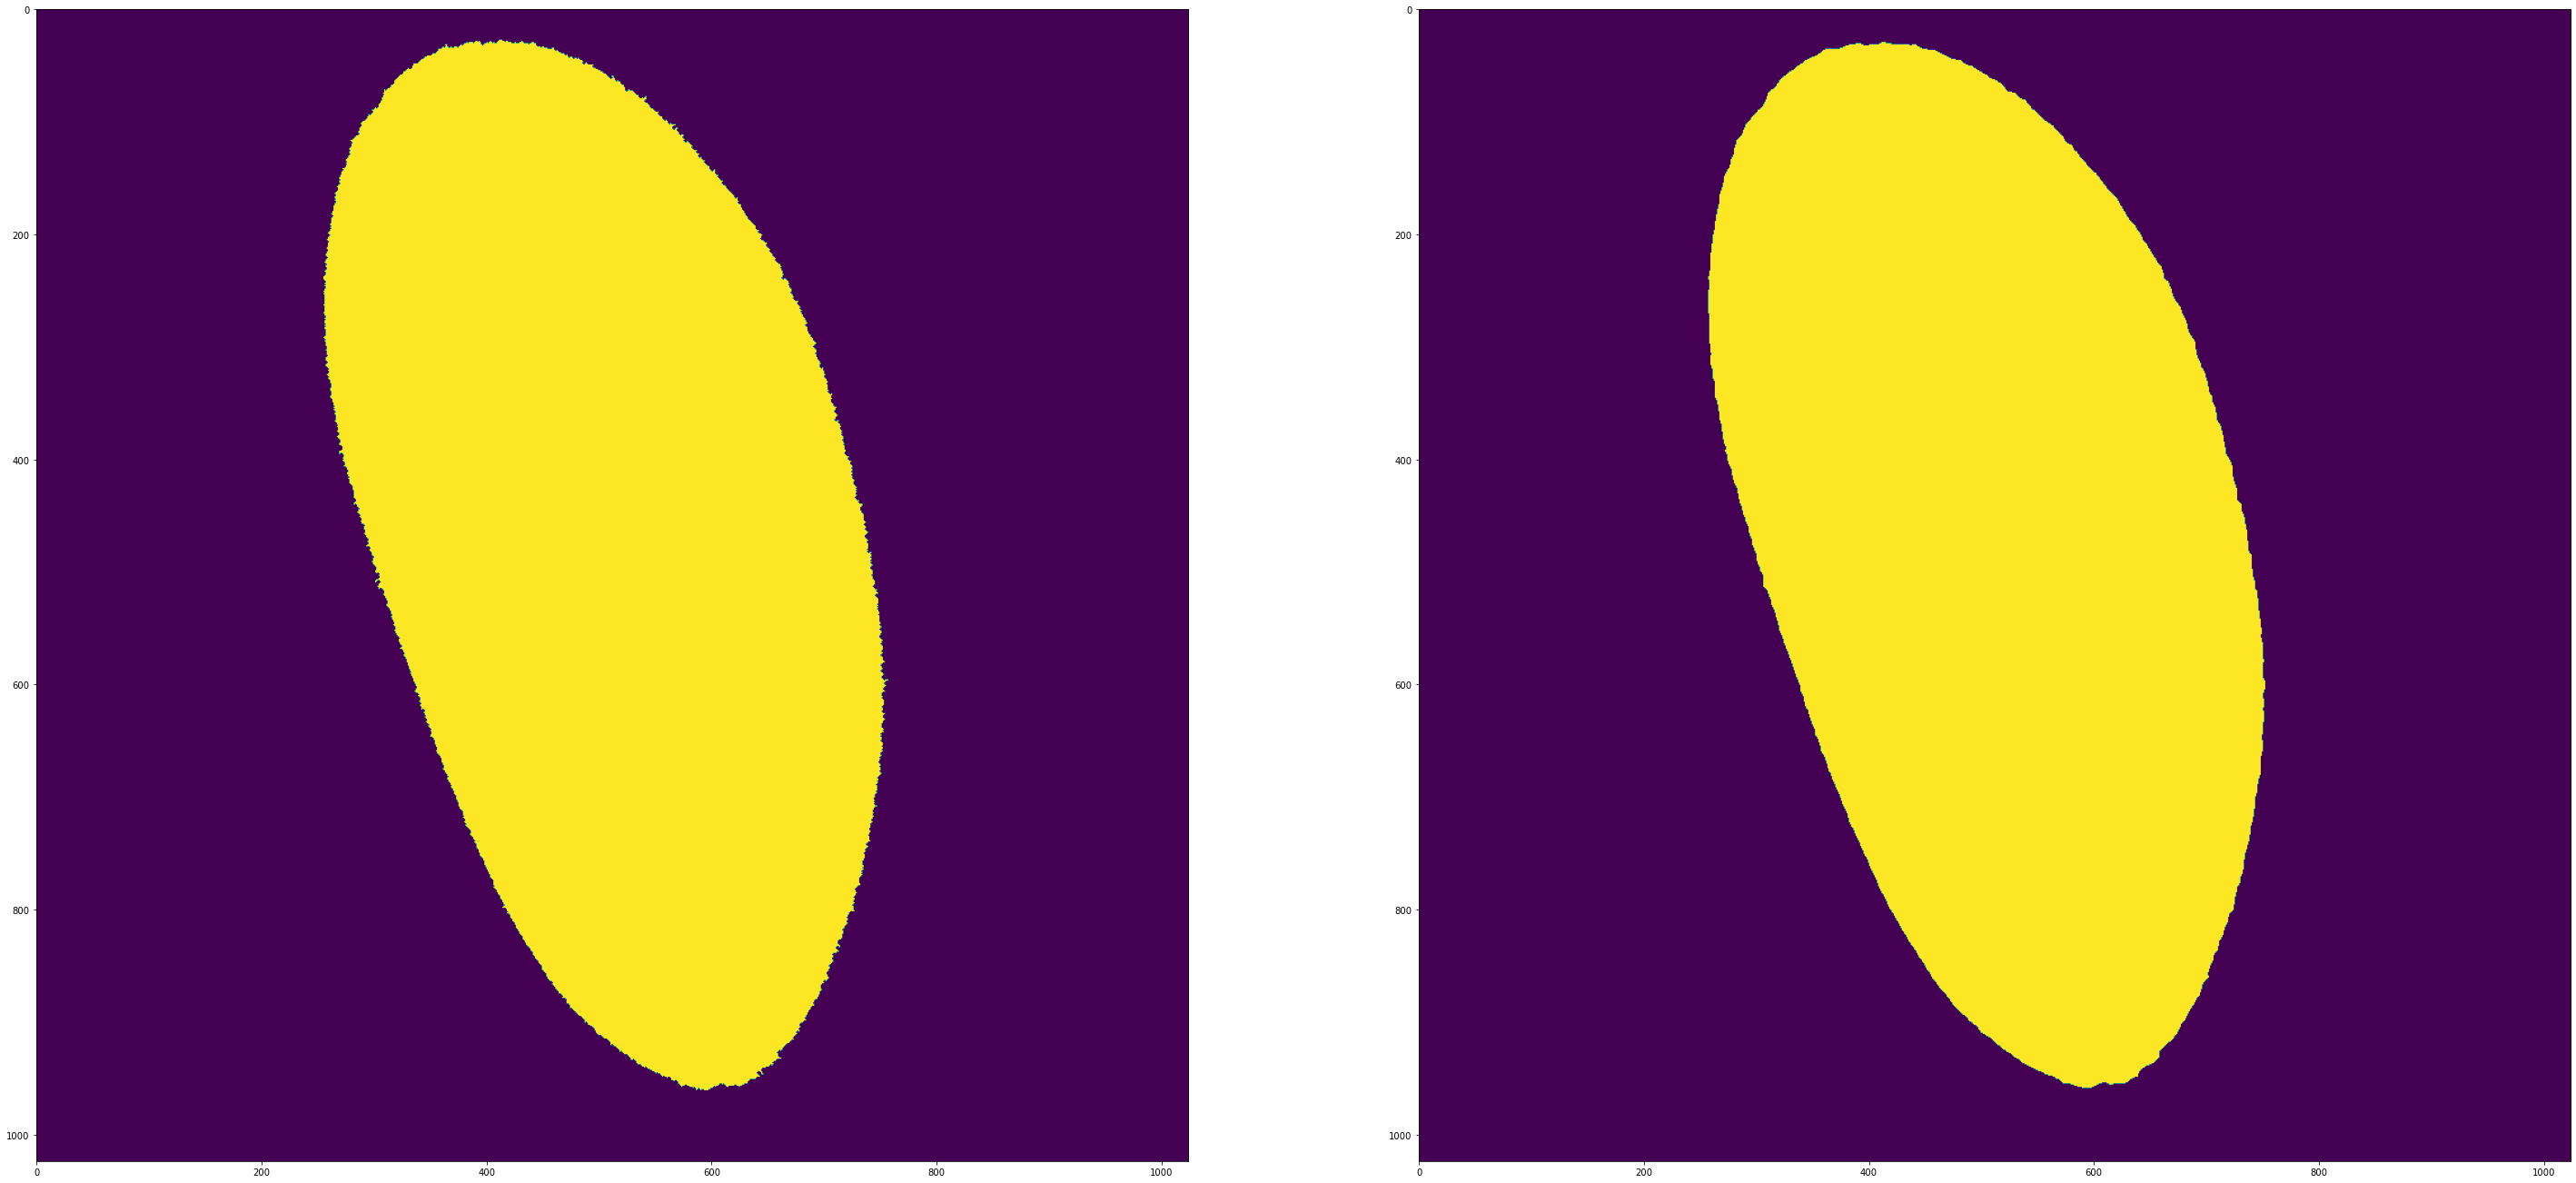

In [7]:
# make a better outline of the embryo for masks

footprint=morphology.disk(25)
dil1 = morphology.binary_dilation(zedge, footprint)
dilated_zedge_shape = morphology.binary_dilation(zedge) # fills a hole in edges
zclosed = morphology.flood(dilated_zedge_shape, (int(y0), int(x0)))

fig, ax = plt.subplots(1,2, figsize=(50,150))
ax[0].imshow(zclosed_v1)
ax[1].imshow(zclosed)

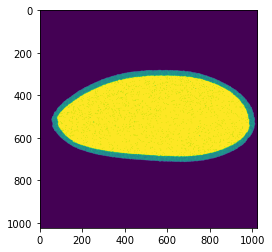

In [8]:
rotation_axis = 90 - (orientation * 180/math.pi)
rotated_embshape = ndimage.rotate(zclosed, rotation_axis, reshape=False)
                                        # WRITE IN A/P IF/ELSE FOR PROPER BEAN FLICKING
flip = True
if flip:
    rotated_embshape= np.fliplr(rotated_embshape)

plt.imshow(rotated_embshape)

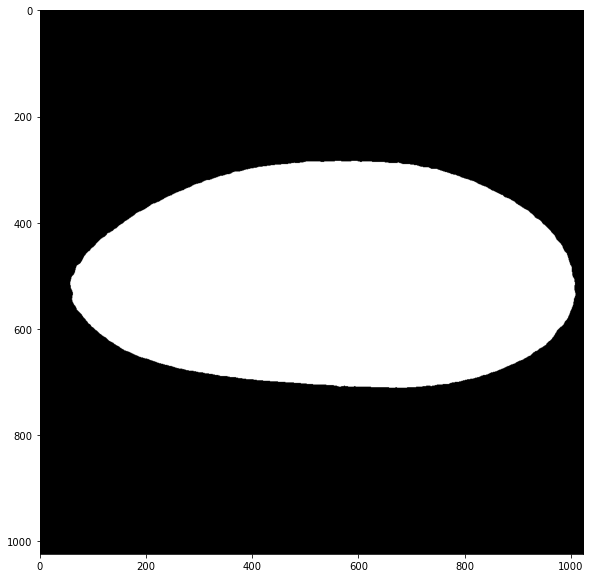

In [9]:
#series of commands to make a nice emb shape again
rotated_embshape = exposure.adjust_gamma(rotated_embshape)
rotated_embshape = filters.apply_hysteresis_threshold(rotated_embshape, bkgd_signal, np.max(rotated_embshape)-1)
rotated_embshape = morphology.binary_closing(rotated_embshape)
rotated_embshape = canny(rotated_embshape, sigma=2.0, low_threshold=0.55, high_threshold=0.8) 
rotated_embshape = morphology.binary_dilation(rotated_embshape) # fills a hole in edges
rotated_embshape = morphology.flood(rotated_embshape, (int(y0), int(x0)))

fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(rotated_embshape, cmap=plt.cm.gray)  


#rotate embryo shape
rot_zedge = canny(rotated_embshape, sigma=2.0, low_threshold=0.55, high_threshold=0.8) 

In [30]:
# regionprops on the rotated embryo

emb_label= label(rotated_embshape.astype(np.uint8))
emb_regions = regionprops(rotated_embshape.astype(np.uint8))

for props in emb_regions:
    y0, x0 = props.centroid
    orientation_rot = props.orientation
    long_axis = props.major_axis_length
    short_axis = props.minor_axis_length
    minr, minc, maxr, maxc = props.bbox

    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length #top
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x3 = x0 - math.cos(orientation) * 0.5 * props.minor_axis_length #bottom
    y3 = y0 + math.sin(orientation) * 0.5 * props.minor_axis_length
    
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length
    x4 = x0 + math.sin(orientation) * 0.5 * props.major_axis_length
    y4 = y0 + math.cos(orientation) * 0.5 * props.major_axis_length

# fig, ax = plt.subplots(figsize=(25,25))
# ax.imshow(rotated_embshape, cmap=plt.cm.gray)

# ax.plot((x3, x1), (y3, y1), '-y', linewidth=2.5) #minor axis line
# ax.plot((x4, x2), (y4, y2), '-m', linewidth=2.5) #major axis line
# ax.plot(x0, y0, '.g', markersize=15)

# bx = (minc, maxc, maxc, minc, minc)
# by = (minr, minr, maxr, maxr, minr)
# ax.plot(bx, by, '-p', linewidth=2.5)

# plt.show()

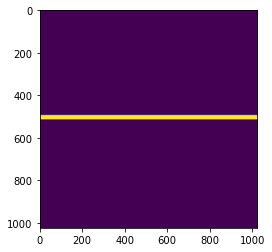

In [11]:
# making the knives on the rotated embryo

minor_axis_line = np.zeros((ydim, xdim), dtype=bool)
major_axis_line = np.zeros((ydim, xdim), dtype=bool)

m_minor = (y1 - y0) / (x1 - x0)
b_minor = (y1 - (m_minor * x1))
m_major = (y2 - y0) / (x2 - x0)
b_major = (y2 - (m_major * x2))

# minor axis loop
minor_inds = []
for x in range(minor_axis_line.shape[1]):
    y = ((m_minor * x) + b_minor)
    if y < minor_axis_line.shape[1] and y >= 0:
        minor_axis_line[int(y),int(x)] = True
        minor_inds.append((int(y), (int(x))))

# major axis loop
major_inds = [] # list
for x in range(major_axis_line.shape[0]):
    y = ((m_major * x) + b_major)
    if y < major_axis_line.shape[0] and y >= 0:
        major_axis_line[int(y),int(x)] = True
        major_inds.append([int(y), int(x)])


footprint=morphology.disk(10)

major_axis_knife = morphology.binary_dilation(major_axis_line, footprint)
minor_axis_knife = morphology.binary_dilation(minor_axis_line, footprint)

fig, ax = plt.subplots()
ax.imshow(minor_axis_knife + major_axis_knife)

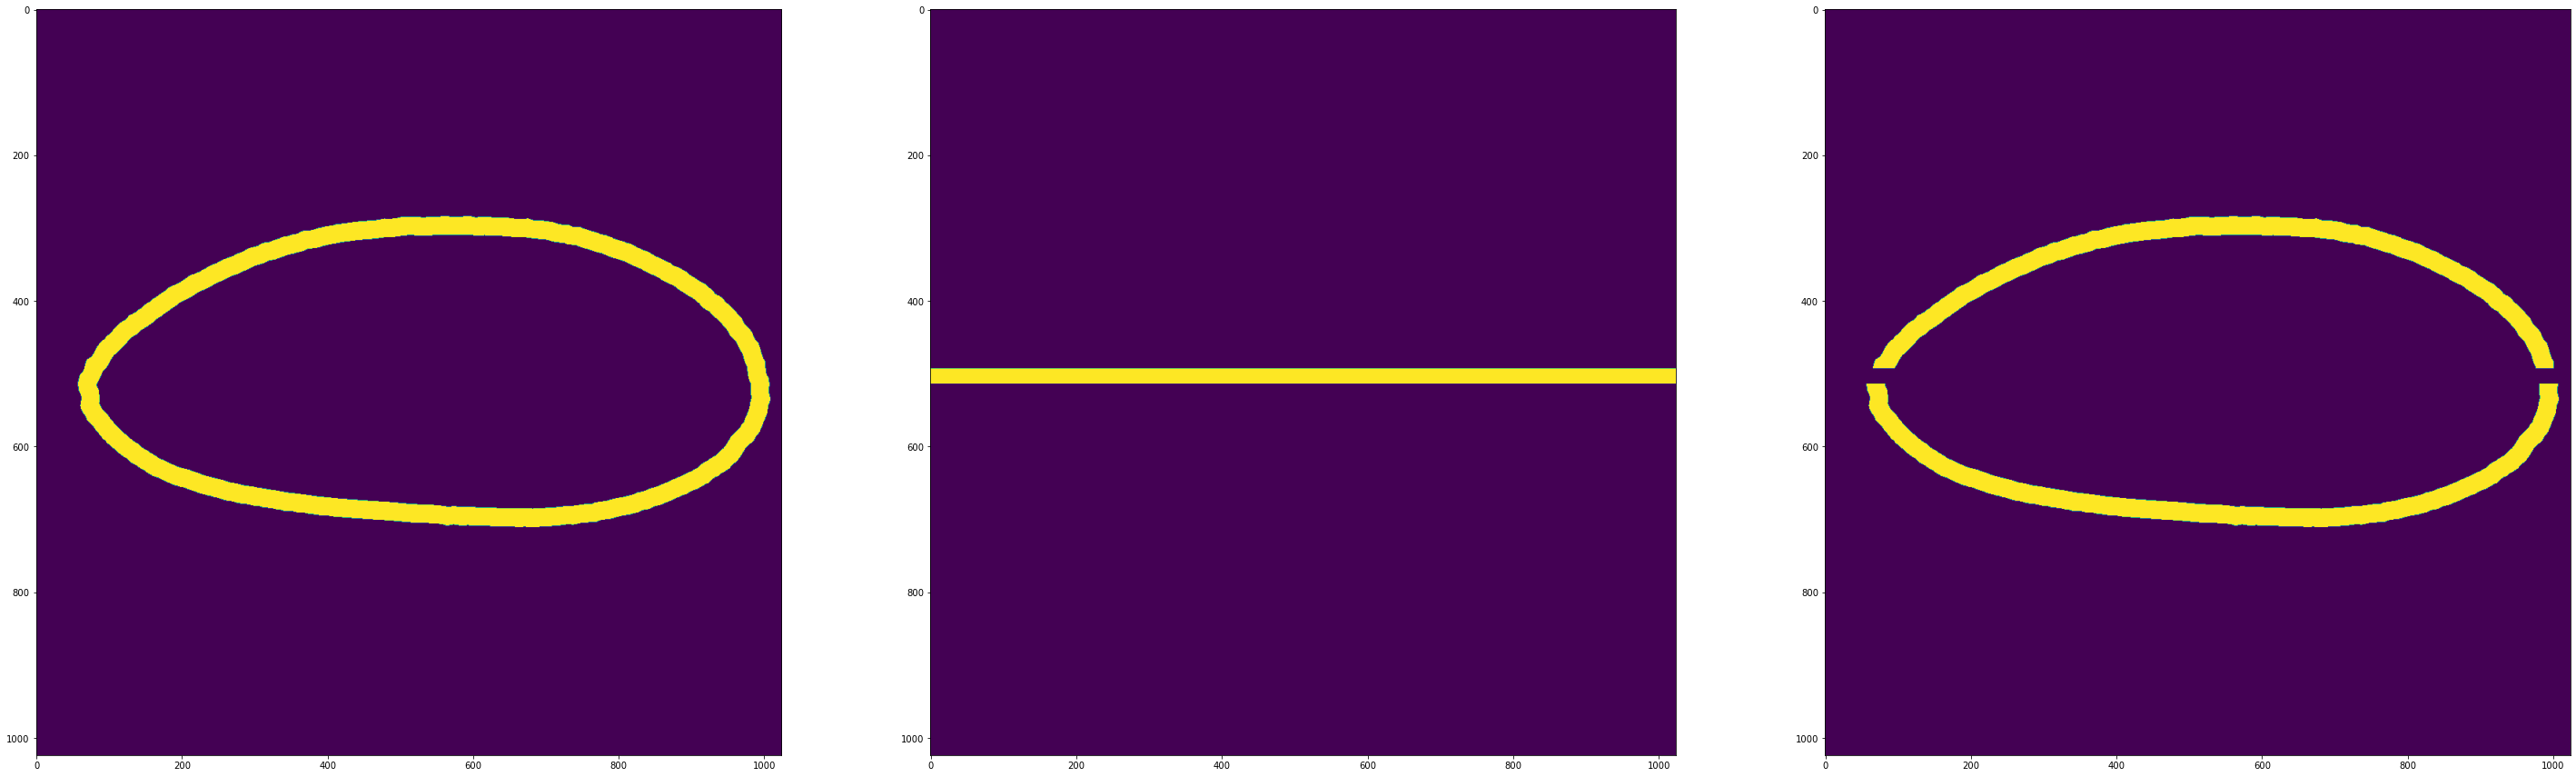

In [12]:
# get the dorsal ventral 

footprint=morphology.disk(25)
dil = morphology.binary_dilation(rot_zedge, footprint)

# makes a better oval from edges
#dilated_edge = morphology.binary_dilation(rot_edge_slice) # fills a hole in edges
#better_closed = morphology.flood(dilated_edge, (int(y0), int(x0)))

zorro = rotated_embshape*dil # slices off all the extra in dil 1 to make a mask of the area of interest in the embryo
dv_divide = np.invert(major_axis_knife) * zorro # cuts the zorro mask with the knife

fig, ax = plt.subplots(1,3, figsize=(50,150))
ax[0].imshow(zorro)
ax[1].imshow(major_axis_knife)
ax[2].imshow(dv_divide)

In [23]:
# get DV side
dv_label = label(dv_divide)
dv_regions = regionprops(dv_label)
dv_props = regionprops_table(dv_label, properties=('area', 'perimeter', 'bbox'))
#pd.DataFrame(dv_props)


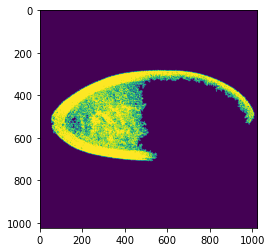

In [48]:
#rotate the DV patterning gene

rotation_axis = 90 - (orientation * 180/math.pi)
rotated_zdv = ndimage.rotate(z_plane_dv, rotation_axis, reshape=False)
                                        # WRITE IN A/P IF/ELSE FOR PROPER BEAN FLICKING
flip = True
if flip:
    rotated_zdv= np.fliplr(rotated_zdv)

rotated_zdv = exposure.adjust_gamma(rotated_zdv) #normalize for better detection
hyst_zdv = filters.apply_hysteresis_threshold(rotated_zdv, bkgd_signal, np.max(rotated_zdv)-1)


plt.imshow(hyst_zdv)

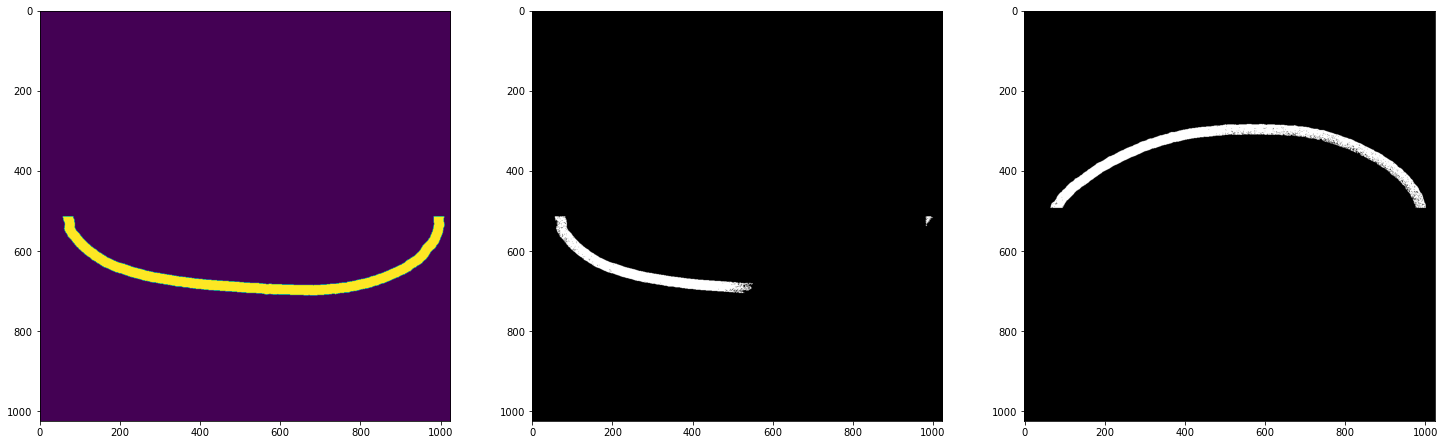

In [50]:
blank = np.zeros((ydim, xdim), dtype=bool)
sideA = blank.copy()
bbox = dv_regions[0].bbox
sideA[bbox[0]:bbox[2], bbox[1]:bbox[3]] = dv_regions[0].image

sideB = blank.copy()
bbox = dv_regions[1].bbox
sideB[bbox[0]:bbox[2], bbox[1]:bbox[3]] = dv_regions[1].image

# use the two sides and mask the snail hysterics image


decide_A =  hyst_zdv*sideA
decide_B =  hyst_zdv*sideB

# decision point for the DV axis

if np.sum(decide_A) > np.sum(decide_B):
    dorsal = sideB
    dorsal_check = decide_B
    garbage = decide_A
else:
         dorsal = sideA
         dorsal_check = decide_A
         garbage = decide_B


fig, ax = plt.subplots(1,3, figsize=(25,25))
ax[0].imshow(dorsal)
ax[1].imshow(dorsal_check, cmap=plt.cm.gray)
ax[2].imshow(garbage, cmap=plt.cm.gray)